In [1]:
import time

import numpy as np
import pandas as pd
import theano as th
import theano.tensor as T

In [2]:
class Autoencoder(object):
    
    def __init__(self, layers, activ='tanh', update='sgd', lr=0.0003, batch=1, memo = 0.3):
        self.x = T.matrix()
        self.y_hat = T.matrix()
        self.layers = layers
        self.activ, self.update = self.choose(activ, update)
        self.batch = batch; self.lr = lr; self.memo = memo
        self.weights = []; self.biases = []
        self.auxiliary = []
        self.a_n = [self.x]
        
    def choose(self, activ, update):
        """Choose the activation and update function"""
        Acti = dict({'tanh':self.tanh,'sigmoid':self.sigmoid,'ReLU':self.ReLU,'linear':self.linear})
        Upda = dict({'sgd':self.sgd,'NAG':self.NAG,'RMSProp':self.RMSProp,'momentum':self.momentum})
        return Acti[activ], Upda[update] 
        
    def architecture(self, cons, code_layer):
        """Build up the architecture by theano"""
        for i in range(len(self.layers)-1):
            #Initialize shared variables
            self.weights.append(th.shared(cons*np.random.randn(self.layers[i],self.layers[i+1])))
            self.biases.append(th.shared(cons*np.random.randn(self.layers[i+1])))
            #Building architecture
            a_next = self.activ(T.dot(self.a_n[i],self.weights[i]) + self.biases[i].dimshuffle('x',0))
            self.a_n.append(a_next)
        
        #help the optimization
        for param in (self.weights+self.biases):    
            self.auxiliary.append(th.shared(np.zeros(param.get_value().shape)))
            
        self.encode = th.function([self.x],self.a_n[code_layer]) 
        self.decode = th.function([self.a_n[code_layer]],self.a_n[-1])
        
        #Calculate the cost and gradients
        Cost = (T.sum((self.a_n[-1]-self.y_hat)**2))/self.batch
        grads = T.grad(Cost,self.weights+self.biases,disconnected_inputs='ignore') 
        #Update parameters
        self.gradient_2 = th.function(inputs=[self.x,self.y_hat],updates=
                                      self.update(self.weights+self.biases,grads,self.auxiliary),outputs=Cost)
            
    def fit(self, X, code_layer=1, epoch=10, print_every=1, cons=0.3, denoise=0.005):
        """fitting the data (unsupervised learning)"""
        self.architecture(cons, code_layer)
        start = time.clock(); self.Cost_Record = []   
        for j in range(epoch):
            costs = 0
            rounds = int(X.shape[0]/self.batch)
            X_permuted = X[np.random.permutation(X.shape[0])]
            noise = np.random.randn(X.shape[0], X.shape[1])*X_permuted.std(axis=0)
            X_permuted += noise*denoise
            
            for i in range(rounds):
                batch_X = X_permuted[i*self.batch:(i+1)*self.batch]
                costs += self.gradient_2(batch_X,batch_X)

            self.Cost_Record.append(costs/rounds)
            
            if j % print_every == 0:
                print("Epoch %d ; Cost: %f; %f seconds used."%(j+1,self.Cost_Record[-1],(time.clock()-start)))
    
    def encode(self, X):
        return self.encode(X)
    
    def decode(self, X):
        return self.decode(X)
    
    ##### Optimization methods #####
    def sgd(self,para,grad,_):
        """optimized by gradient descent"""
        return [(para[ix], para[ix]-self.lr*grad[ix]) for ix in range(len(grad))]

    def NAG(self,para,grad,Real):
        """optimized by Nesterov accelerated gadient(NAG)"""
        updates = []
        for ix in range(len(grad)):
            #grad[ix] = T.clip(grad[ix],-1,1)
            gradient = -(self.lr/self.batch)*grad[ix]
            spy_position = (1+self.memo)*(para[ix]+gradient)-self.memo*Real[ix]
            updates.append((para[ix], spy_position))
            updates.append((Real[ix], para[ix]+gradient))
        return updates
    
    def momentum(self,para,grad,Momentum):
        """optimized by momentum"""
        updates = []
        for ix in range(len(grad)):
            #grad[ix] = T.clip(grad[ix],-1,1)
            direction = (self.memo)*Momentum[ix] - (self.lr/self.batch)*grad[ix]
            updates.append((para[ix], para[ix]+direction))
            updates.append((Momentum[ix], direction))
        return updates
    
    def RMSProp(self,para,grad,Sigma_square):
        """optimized by RMSProp"""
        updates = []; alpha = self.memo
        for ix in range(len(grad)):
            #grad[ix] = T.clip(grad[ix],-1,1)
            gradient = grad[ix]/self.batch
            Factor = Sigma_square[ix]*alpha+(1-alpha)*(gradient**2)
            direction = -(self.lr)*gradient/(T.sqrt(Factor)+0.001)
            updates.append((para[ix], para[ix]+direction))
            updates.append((Sigma_square[ix], Factor))
        return updates
    
    ##### Activation functions #####               
    def tanh(self, Z):
        return T.tanh(Z)
    
    def ReLU(self, Z):
        return T.switch(Z<0,0,Z)
    
    def sigmoid(self, Z):
        return 1/(1+T.exp(-Z))
    
    def linear(self, Z):
        return Z


In [3]:
data = pd.read_csv('Data/train.dat',header=None,delim_whitespace=True)
coder = Autoencoder([9,64,32,16,2,16,32,64,9], batch=2, activ='tanh', update='RMSProp', memo=0.8, lr=0.001)
coder.fit(data.values, code_layer=4, epoch=2001, print_every=100)

Epoch 1 ; Cost: 4.813664; 0.014526 seconds used.
Epoch 101 ; Cost: 1.431566; 1.532882 seconds used.
Epoch 201 ; Cost: 1.127423; 3.050505 seconds used.
Epoch 301 ; Cost: 0.931415; 4.634072 seconds used.
Epoch 401 ; Cost: 0.763588; 6.133072 seconds used.
Epoch 501 ; Cost: 0.655769; 7.639055 seconds used.
Epoch 601 ; Cost: 0.586990; 9.114935 seconds used.
Epoch 701 ; Cost: 0.505899; 10.646808 seconds used.
Epoch 801 ; Cost: 0.466384; 12.205964 seconds used.
Epoch 901 ; Cost: 0.431887; 13.739288 seconds used.
Epoch 1001 ; Cost: 0.386706; 15.313681 seconds used.
Epoch 1101 ; Cost: 0.376895; 16.813711 seconds used.
Epoch 1201 ; Cost: 0.328889; 18.328748 seconds used.
Epoch 1301 ; Cost: 0.299646; 19.816789 seconds used.
Epoch 1401 ; Cost: 0.287231; 21.285019 seconds used.
Epoch 1501 ; Cost: 0.242835; 22.749620 seconds used.
Epoch 1601 ; Cost: 0.225762; 24.230938 seconds used.
Epoch 1701 ; Cost: 0.224149; 25.709938 seconds used.
Epoch 1801 ; Cost: 0.184800; 27.220697 seconds used.
Epoch 1901 ;

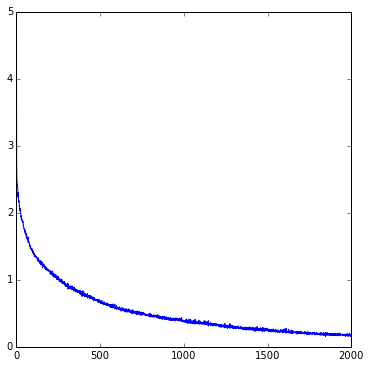

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(coder.Cost_Record)

In [5]:
code = coder.encode(data.values)
np.set_printoptions(4)
print('encode:\n',code[:5])
print('decode:\n',coder.decode(code)[:5])
print('original:\n',data.values[:5])

encode:
 [[-0.3199 -0.3034]
 [ 0.7191 -0.5755]
 [ 0.3189 -0.4277]
 [ 0.9186 -0.9192]
 [ 0.104  -0.6343]]
decode:
 [[ 0.812  -0.5116  0.4948  0.5328 -0.7794  0.6674  0.6818 -0.2716 -0.5186]
 [-0.6045 -0.0514  0.7796  0.0119  0.2946 -0.4479  0.0592  0.5272 -0.7022]
 [ 0.2469 -0.0233  0.4548 -0.5035 -0.6908  0.5951 -0.9031  0.7063 -0.6783]
 [-0.9352  0.7119 -0.2632 -0.8903  0.0868 -0.8843 -0.4798  0.9617  0.9413]
 [ 0.7913 -0.0493  0.272   0.281   0.8274  0.6346 -0.2271  0.9037  0.3844]]
original:
 [[ 0.8105 -0.35    0.4769  0.4541 -0.9829  0.5252  0.3838 -0.3408 -0.4824]
 [-0.6273 -0.2097  0.9404  0.1143  0.3487 -0.5206  0.0061  0.5024 -0.6687]
 [ 0.1624 -0.1173  0.426  -0.3607 -0.6632  0.4431 -0.8355  0.7206 -0.8977]
 [-1.      0.7758 -0.267  -0.888  -0.1099 -0.9183 -0.4086  0.8962  0.5841]
 [ 0.8464  0.1762  0.2729  0.2724  0.8155  0.6096 -0.2844  0.98    0.3302]]
